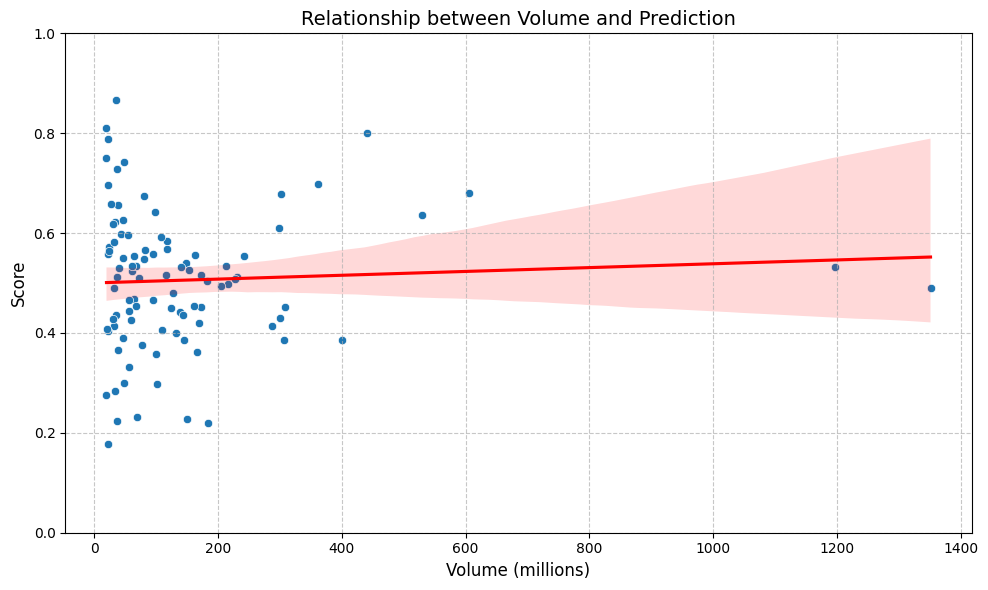

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import json
with open("data/manifold_03012024_small_gpt-4o_7_adam_search_outputs.json") as file:
    data = json.load(file)

# Assuming 'data' is your list of dictionaries
volumes = [market['uniqueBettorCount'] for market in data]
# predictions = [market['prediction'] for market in data]
# brier_score = [(market['prediction'] - (market['resolution'] == 'YES')) ** 2 for market in data]
brier_score = [market['crowd_pred'] for market in data]

# Set the style for the plot
# plt.style.use('seaborn')

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=volumes, y=brier_score)

# Set labels and title
plt.xlabel('Volume', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Relationship between Volume and Prediction', fontsize=14)

# Add a trend line
sns.regplot(x=volumes, y=brier_score, scatter=False, color='red')

# Scale x-axis to millions for better readability
plt.ticklabel_format(style='plain', axis='x', scilimits=(0,0))
plt.xlabel('Volume (millions)', fontsize=12)

# Adjust y-axis to show probabilities
plt.ylim(0, 1)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1])

# Add grid lines
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

len_data= 91


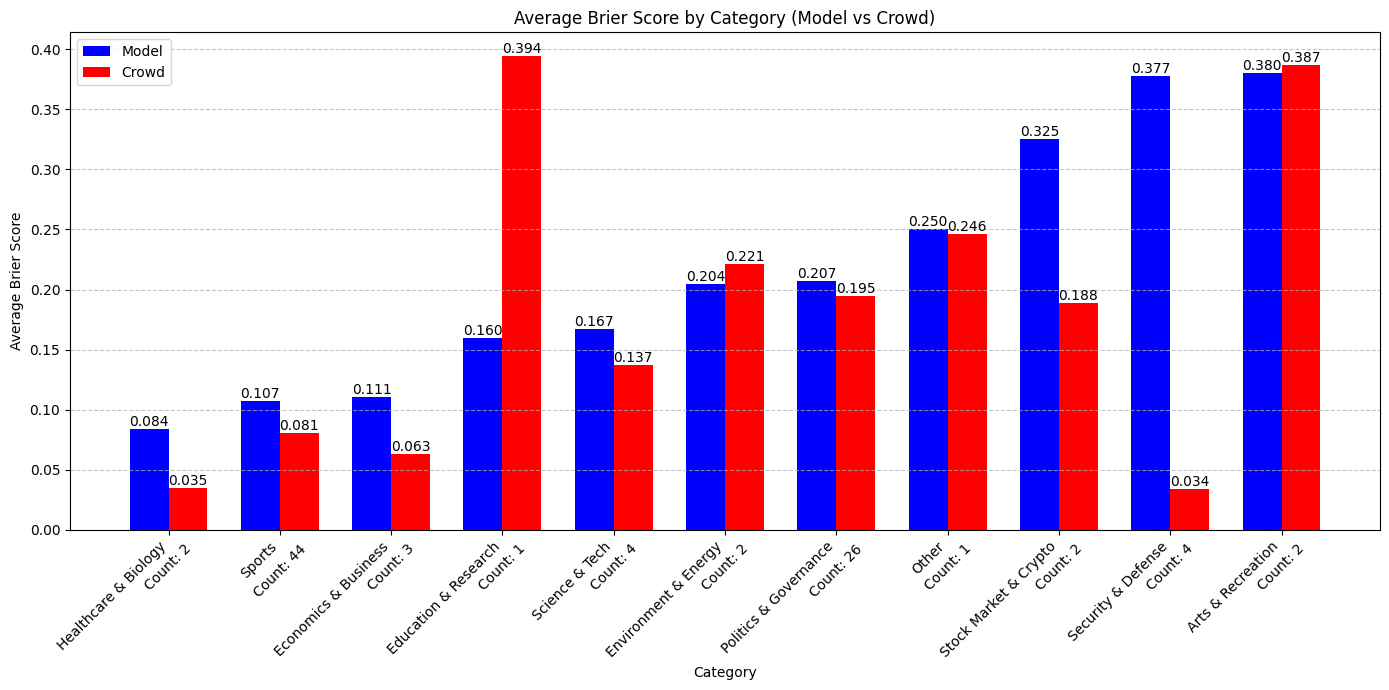

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

def calculate_brier_score(prediction, actual):
    return (prediction - actual) ** 2

def generate_brier_score_plot(data):
    # Calculate Brier scores and group by category
    category_scores_model = defaultdict(list)
    category_scores_crowd = defaultdict(list)
    category_counts = defaultdict(int)
    for item in data:
        actual = 1 if item['resolution'] == 'YES' else 0
        brier_score_model = calculate_brier_score(item['predictions'][0], actual)
        brier_score_crowd = calculate_brier_score(item['crowd_pred'][3][-1], actual)
        category_scores_model[item['category']].append(brier_score_model)
        category_scores_crowd[item['category']].append(brier_score_crowd)
        category_counts[item['category']] += 1
    
    # Calculate average Brier score for each category
    categories = []
    avg_scores_model = []
    avg_scores_crowd = []
    counts = []
    for category in category_scores_model.keys():
        categories.append(category)
        avg_scores_model.append(np.mean(category_scores_model[category]))
        avg_scores_crowd.append(np.mean(category_scores_crowd[category]))
        counts.append(category_counts[category])
    
    # Sort categories by average Brier score of the model
    sorted_indices = np.argsort(avg_scores_model)
    categories = [categories[i] for i in sorted_indices]
    avg_scores_model = [avg_scores_model[i] for i in sorted_indices]
    avg_scores_crowd = [avg_scores_crowd[i] for i in sorted_indices]
    counts = [counts[i] for i in sorted_indices]
    
    # Create the plot
    plt.figure(figsize=(14, 7))
    x = np.arange(len(categories))
    width = 0.35
    
    bars1 = plt.bar(x - width/2, avg_scores_model, width, label='Model', color='blue')
    bars2 = plt.bar(x + width/2, avg_scores_crowd, width, label='Crowd', color='red')
    
    plt.title('Average Brier Score by Category (Model vs Crowd)')
    plt.xlabel('Category')
    plt.ylabel('Average Brier Score')
    plt.xticks(x, categories, rotation=45, ha='right')
    plt.legend()
    
    # Add value labels on top of each bar
    def autolabel(bars, scores):
        for i, bar in enumerate(bars):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, height,
                     f'{scores[i]:.3f}',
                     ha='center', va='bottom')
    
    autolabel(bars1, avg_scores_model)
    autolabel(bars2, avg_scores_crowd)
    
    # Add count labels below the category names
    for i, count in enumerate(counts):
        plt.text(i, -0.01, f'Count: {count}', ha='center', va='top', rotation=45)
    
    # Add a light grid for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Adjust layout to prevent cut-off labels
    plt.tight_layout()
    
    plt.show()

import json
# Use the function as before
with open("output/test_full.json") as file:
    data = json.load(file)
print("len_data=", len(data))
generate_brier_score_plot(data)

In [34]:
import json
import numpy as np

def brier_score(prediction, actual):
    return (prediction - actual) ** 2

def check_accuracy(data):
    model_correct = 0
    crowd_correct = 0
    model_scores = []
    crowd_scores = []
    total_predictions = 0

    for item in data:
        if "bitcoin" in item['question'].lower():
            # print(item['question'])
            continue
        # Check if the item has all the required fields
        if all(key in item for key in ['prediction', 'crowd_pred', 'resolution']):
            total_predictions += 1
            
            actual_yes = item['resolution'] == "YES"

            # Convert predictions to boolean (True if > 0.5, False otherwise)
            model_prediction = item['prediction']
            crow_pred = item['crowd_pred']

            model_score = brier_score(model_prediction, actual_yes)
            crowd_score = brier_score(crow_pred, actual_yes)
            model_scores.append(model_score) 
            crowd_scores.append(crowd_score)

            model_predicted_yes = item['prediction'] > 0.5
            crowd_predicted_yes = item['crowd_pred'] > 0.5
            
            # Convert resolution to boolean (True if "YES", False if "NO")
            
            # Check if predictions match actual resolution
            if model_predicted_yes == actual_yes:
                model_correct += 1
            if crowd_predicted_yes == actual_yes:
                crowd_correct += 1

    # Calculate accuracies
    if total_predictions > 0:
        model_accuracy = model_correct / total_predictions
        crowd_accuracy = crowd_correct / total_predictions
    else:
        model_accuracy = 0.0
        crowd_accuracy = 0.0

    return {
        "model_accuracy": model_accuracy,
        "crowd_accuracy": crowd_accuracy,
        "model_brier_score": np.mean(model_scores),
        "crowd_brier_score": np.mean(crowd_scores)
    }

with open("output/test_full.json") as file:
    data = json.load(file)

# Example usage:
accuracies = check_accuracy(data)
print(f"Model Accuracy: {accuracies['model_accuracy']:.2%}")
print(f"Crowd Accuracy: {accuracies['crowd_accuracy']:.2%}")

print(f"Model Brier Score: {accuracies['model_brier_score']:.2%}")
print(f"Crowd Brier Score: {accuracies['crowd_brier_score']:.2%}")

Model Accuracy: 73.31%
Crowd Accuracy: 88.85%
Model Brier Score: 19.15%
Crowd Brier Score: 14.34%


In [13]:
import json
import numpy as np
from collections import defaultdict

def load_json(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

def compute_brier_score(prediction, actual):
    return (prediction - actual) ** 2

# List of file paths
files = ['run0_factorized.json', 'run1_factorized.json', 'run2_factorized.json']
files = ["output/"+f for f in files]
# Dictionary to store predictions for each question ID
predictions_by_id = defaultdict(list)
labels_by_id = defaultdict(list)

# Load data from all files
for file in files:
    data = load_json(file)
    for item in data:
        question_id = item['id']
        prediction = item['prediction']
        predictions_by_id[question_id].append(prediction)
        labels_by_id[question_id] = int(item['resolution'] == "YES")
# Compute ensemble predictions and Brier scores
ensemble_brier_scores = []

for question_id, predictions in predictions_by_id.items():
    # Compute ensemble prediction (average)
    ensemble_prediction = np.mean(predictions)
        
    brier_score = compute_brier_score(ensemble_prediction, labels_by_id[question_id])
    ensemble_brier_scores.append(brier_score)

# Compute the average Brier score
average_ensemble_brier_score = np.mean(ensemble_brier_scores)

print(f"Average Ensemble Brier Score: {average_ensemble_brier_score}")

Average Ensemble Brier Score: 0.22453940435280645


In [36]:
import json

with open("/data/long_phan/forecasting_platform/backend/src/benchmarks/output/test_full.json") as file:
    data = json.load(file)

for market in data:
    if market['resolutionTime'] < market['lastBetTime']:
        print(market)


{'id': 'QXBUUMEkqYQEvhVps8zo', 'question': 'Will Jimmy Carter live to see Trump debate Biden?', 'background_text': 'Resolves YES if he is alive when the debate starts', 'tags': ['longevity', 'jimmy-carter', 'donald-trump', 'the-life-of-biden', '2024-us-presidential-election'], 'resolution': 'YES', 'resolutionTime': 1719544650221, 'resolutionTimeStr': '2024-06-27', 'lastBetTime': 1719677485755, 'lastBetTimeStr': '2024-06-29', 'crowd_pred': 0.5844155844155844, 'volume': 44621.06122497694, 'category': 'Politics & Governance', 'prediction': 0.75, 'response': "# Analysis of Jimmy Carter's Health and Longevity\n\n## Current Health Status\nJimmy Carter, the 39th President of the United States, has been in hospice care since February 2023. Despite the typical prognosis for hospice patients, Carter has defied the odds by surviving over 16 months in hospice care. This is notable given that more than 90% of hospice patients die within the first six months, and nearly 40% die within the first week

In [2]:
from datasets import load_dataset

dataset = load_dataset("YuehHanChen/forecasting", split="test")
dataset = dataset.filter(lambda x: "manifold.markets" in x['url'] and "binary" in x['question_type'].lower() and "bitcoin" not in x['question'].lower())
len(dataset)

/data/long_phan/anaconda3/lib/python3.10/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.19) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


286

In [3]:
import ast
import numpy as np
def compute_brier_score(prediction, actual):
    return (prediction - actual) ** 2

preds = []
labels = []
scores = []
for market in dataset:
    pred = ast.literal_eval(market['community_predictions'])[-1][-1]
    label = market['resolution']
    score = compute_brier_score(pred, label)
    scores.append(score)

np.mean(scores)

0.09864454239527672

In [52]:
market

{'question_type': 'BINARY',
 'background': 'Will the FTSE 100 close higher on Wednesday 31st May than it did on Tuesday 30th May? The market closes at 16:30 UK time when trading stops on the FTSE. And here are some longer term FTSE markets:',
 'url': 'https://manifold.markets/SimonGrayson/will-the-uks-ftse-100-close-higher-334c73f8c80b',
 'community_predictions': '[["2023-05-30", 0.45231208163306175], ["2023-05-30", 0.509900019603999], ["2023-05-30", 0.509900019603999], ["2023-05-31", 0.0011502506366766663], ["2023-05-31", 0.0011617568519265357], ["2023-05-31", 0.004453813822257174], ["2023-05-31", 0.004484658917608306], ["2023-05-31", 0.017992245392002996], ["2023-05-31", 0.02406020519822627], ["2023-05-31", 0.037549468097123], ["2023-05-31", 0.04904301967183287], ["2023-05-31", 0.06133718432882184], ["2023-05-31", 0.0813189934841926], ["2023-05-31", 0.17054879508376605], ["2023-05-31", 0.21021797866286132], ["2023-05-31", 0.21330009292469512], ["2023-05-31", 0.21781039002957855], ["2

In [7]:
import ast
import numpy as np
from datetime import datetime, timedelta

def compute_brier_score(pred, label):
    return (pred - label) ** 2

def get_retrieval_dates(date_begin, date_close, n=5):
    date_begin = datetime.strptime(date_begin, "%Y-%m-%d")
    date_close = datetime.strptime(date_close, "%Y-%m-%d")
    total_days = (date_close - date_begin).days
    
    retrieval_dates = [date_begin + timedelta(days=int((total_days ** (k/n)) - 1)) for k in range(1, n+1)]
    return [date.strftime("%Y-%m-%d") for date in retrieval_dates]

def get_pred_before_date(predictions, target_date):
    target_date = datetime.strptime(target_date, "%Y-%m-%d")
    valid_preds = [p for p in predictions if datetime.strptime(p[0], "%Y-%m-%d") <= target_date]
    return valid_preds[-1][1] if valid_preds else None

preds = []
labels = []
scores = []

for market in dataset:
    predictions = ast.literal_eval(market['community_predictions'])
    label = market['resolution']
    
    retrieval_dates = get_retrieval_dates(market['date_begin'], market['date_close'])
    
    market_scores = []
    for date in retrieval_dates:
        pred = get_pred_before_date(predictions, date)
        if pred is not None:
            score = compute_brier_score(pred, label)
            market_scores.append(score)
    
    if market_scores:
        avg_score = np.mean(market_scores)
        scores.append(avg_score)

overall_score = np.mean(scores)
print(f"Overall average Brier score: {overall_score}")

Overall average Brier score: 0.20028553523745704


market['q'] Will the LK-99 room temp, ambient pressure superconductivity pre-print replicate before August 15, 2023?
len(retrieval_dates)= ['2023-07-26', '2023-07-28', '2023-07-30', '2023-08-04', '2023-08-13']
valid_dates= [['2023-08-04', 0.13353581483135732], ['2023-08-04', 0.1344895058663302], ['2023-08-04', 0.1344895058663302], ['2023-08-04', 0.1344895058663302], ['2023-08-04', 0.1344895058663302], ['2023-08-04', 0.1344895058663302], ['2023-08-04', 0.1344895058663302], ['2023-08-04', 0.1344895058663302], ['2023-08-04', 0.1399999999999999], ['2023-08-04', 0.1399999999999999], ['2023-08-04', 0.1399999999999999], ['2023-08-04', 0.14378312346437258], ['2023-08-04', 0.14405009167190036], ['2023-08-04', 0.14405009167190036], ['2023-08-04', 0.14737543766974898], ['2023-08-04', 0.15000000000000005], ['2023-08-04', 0.15000000000000005], ['2023-08-04', 0.15000000000000005], ['2023-08-04', 0.15000000000000005], ['2023-08-04', 0.15000000000000005], ['2023-08-04', 0.15000000000000005], ['2023-08

market['q'] Will Xi Jinping visit the US by the end of 2023?
len(retrieval_dates)= ['2023-06-17', '2023-06-22', '2023-07-05', '2023-08-09', '2023-11-13']
valid_dates= [['2023-11-13', 0.971721781590114], ['2023-11-13', 0.9722420597356578], ['2023-11-13', 0.9732774300770718], ['2023-11-13', 0.9733982325346489], ['2023-11-13', 0.9772759382335235], ['2023-11-13', 0.9814015277355149], ['2023-11-13', 0.9817540801947305], ['2023-11-13', 0.981764613842824], ['2023-11-13', 0.9819971735940832], ['2023-11-13', 0.9822952377297246]]
market['q'] Will the USD/RUB exchange rate exceed 100 for at least 1 month in 2023?
len(retrieval_dates)= ['2023-07-09', '2023-07-14', '2023-07-27', '2023-09-01', '2023-12-09']
valid_dates= [['2023-12-09', 0.007409183485074039], ['2023-12-09', 0.008228496700622225]]
market['q'] Will Nvidia's share price break $500 in 2023?
len(retrieval_dates)= ['2023-08-02', '2023-08-04', '2023-08-07', '2023-08-12', '2023-08-23']
valid_dates= [['2023-08-02', 0.20410386855494522], ['202

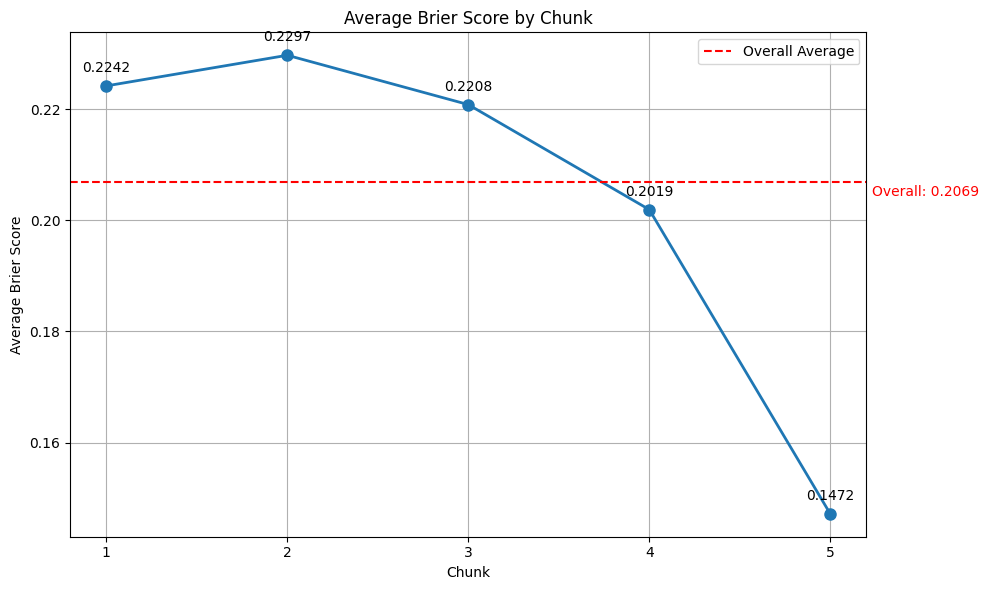

Overall average Brier score: 0.2069365585395254
Average Brier scores by chunk:
Chunk 1: 0.22418531385492513
Chunk 2: 0.22969797626617025
Chunk 3: 0.22081915428384966
Chunk 4: 0.20191983756929768
Chunk 5: 0.14717033116480763
348.486013986014


In [49]:
import ast
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

def compute_brier_score(pred, label):
    return (pred - label) ** 2

def get_retrieval_dates(date_begin, date_close, n=5):
    date_begin = datetime.strptime(date_begin, "%Y-%m-%d")
    date_close = datetime.strptime(date_close, "%Y-%m-%d")
    total_days = (date_close - date_begin).days

    retrieval_dates = [date_begin + timedelta(days=int((total_days ** (k/n)) - 1)) for k in range(1, n+1)]
    
    return [date.strftime("%Y-%m-%d") for date in retrieval_dates]

def get_pred_before_date(predictions, target_date):
    target_date = datetime.strptime(target_date, "%Y-%m-%d")
    valid_preds = [p for p in predictions if datetime.strptime(p[0], "%Y-%m-%d") <= target_date]
    if not valid_preds: 
        return None
    date = valid_preds[-1][0]
    valid_dates = [d for d in valid_preds if d[0] == date]
    print("valid_dates=",valid_dates)
    return valid_dates[0][1] if valid_preds else None

chunk_scores = [[] for _ in range(5)]
overall_scores = []

all_predictions_len = []
for market in dataset:
    predictions = ast.literal_eval(market['community_predictions'])
    all_predictions_len.append(len(predictions))
    label = market['resolution']
    
    retrieval_dates = get_retrieval_dates(market['date_begin'], market['date_close'])
    if len(retrieval_dates) < 5:
        continue
    market_scores = []
    print("market['q']", market['question'])
    print("len(retrieval_dates)=", retrieval_dates)
    for i, date in enumerate(retrieval_dates):
        pred = get_pred_before_date(predictions, date)
        if pred is not None:
            score = compute_brier_score(pred, label)
            market_scores.append(score)
            chunk_scores[i].append(score)
    
    if market_scores:
        avg_score = np.mean(market_scores)
        overall_scores.append(avg_score)

# Calculate average scores for each chunk
avg_chunk_scores = [np.mean(scores) for scores in chunk_scores]

# Calculate overall average score
overall_avg_score = np.mean(overall_scores)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), avg_chunk_scores, marker='o', linestyle='-', linewidth=2, markersize=8)
plt.axhline(y=overall_avg_score, color='r', linestyle='--', label='Overall Average')
plt.xlabel('Chunk')
plt.ylabel('Average Brier Score')
plt.title('Average Brier Score by Chunk')
plt.xticks(range(1, 6))
plt.legend()
plt.grid(True)

# Add value labels on the points
for i, score in enumerate(avg_chunk_scores):
    plt.annotate(f'{score:.4f}', (i+1, score), textcoords="offset points", xytext=(0,10), ha='center')

plt.annotate(f'Overall: {overall_avg_score:.4f}', (5, overall_avg_score), textcoords="offset points", xytext=(30,-10), ha='left', color='r')

plt.tight_layout()
plt.show()

print(f"Overall average Brier score: {overall_avg_score}")
print("Average Brier scores by chunk:")
for i, score in enumerate(avg_chunk_scores):
    print(f"Chunk {i+1}: {score}")

print(np.mean(all_predictions_len))

In [6]:
np.mean(all_predictions_len), np.std(all_predictions_len), np.median(all_predictions_len)

(348.486013986014, 303.55825378459906, 265.0)

In [34]:
chunk_scores = [[] for _ in range(5)]
overall_scores = []
from pprint import pprint

def get_pred_before_date(predictions, target_date):
    target_date = datetime.strptime(target_date, "%Y-%m-%d")
    valid_preds = [p for p in predictions if datetime.strptime(p[0], "%Y-%m-%d") <= target_date]
    return valid_preds[-1][1] if valid_preds else None

# def get_pred_before_date(predictions, target_date, before_date):
#     target_date = datetime.strptime(target_date, "%Y-%m-%d")
#     if before_date == None:
#         valid_preds = [p for p in predictions if datetime.strptime(p[0], "%Y-%m-%d") <= target_date]
#         return valid_preds[-1][1] if valid_preds else None
#     else: 
#         valid_preds = [p for p in predictions if before_date < datetime.strptime(p[0], "%Y-%m-%d") <= target_date]
#         return valid_preds[0][1] if valid_preds else None

all_predictions_len = []
import random

for market in dataset:
    predictions = ast.literal_eval(market['community_predictions'])
    all_predictions_len.append(len(predictions))
    label = market['resolution']
    
    retrieval_dates = get_retrieval_dates(market['date_begin'], market['date_close'])
    
    market_scores = []
    before_date = None
    for i, date in enumerate(retrieval_dates):
        # pred = get_pred_before_date(predictions, date)
        pred = get_pred_before_date(predictions, date)
        before_date = datetime.strptime(date, "%Y-%m-%d")
        if pred is not None:
            score = compute_brier_score(pred, label)
            market_scores.append(score)
            chunk_scores[i].append(score)
            if i == 4 and score > 0.1:
                r = random.random()
                if r > 0.1:
                    print(market)
                    print("score=", score)
                    print("date=",date)
                    # print("before_date=",before_date)
                    print("pred=",pred)

                    print("len(retrieval_dates)=",retrieval_dates)


                    assert False
    
    if market_scores:
        avg_score = np.mean(market_scores)
        overall_scores.append(avg_score)

{'question_type': 'BINARY', 'background': '', 'url': 'https://manifold.markets/owenc333/will-the-mega-millions-125-billion', 'community_predictions': '[["2023-08-02", 0.2000000000000001], ["2023-08-02", 0.25000000000000006], ["2023-08-04", 0.200045886376666], ["2023-08-04", 0.23144931609086447], ["2023-08-04", 0.2508141034159535], ["2023-08-04", 0.29000000000000026], ["2023-08-04", 0.30000000000000016], ["2023-08-04", 0.30000000000000016], ["2023-08-04", 0.30000000000000016], ["2023-08-04", 0.30737818327372035], ["2023-08-04", 0.3099999999999999], ["2023-08-04", 0.3365164125605535], ["2023-08-04", 0.34154854588357175], ["2023-08-04", 0.35000000000000003], ["2023-08-04", 0.35000000000000003], ["2023-08-04", 0.35000000000000003], ["2023-08-04", 0.37], ["2023-08-04", 0.386286022796966], ["2023-08-04", 0.39], ["2023-08-04", 0.39101104763479305], ["2023-08-04", 0.39156717505317284], ["2023-08-04", 0.4096896966695852], ["2023-08-04", 0.4100000000000001], ["2023-08-04", 0.4100000000000001], [

AssertionError: 

In [2]:
import json
from scoring import extract_prediction, average_brier_score

with open("/data/long_phan/forecasting_platform/backend/src/benchmarks/output/test_og.json") as file:
    results = json.load(file)

overall_brier_scores = []
crowd_overall_brier_scores = []
all_preds = []
all_labels = []

for chunk in range(0,2):
    preds = [q['predictions'][chunk] for q in results]
    crowd_preds = [q['crowd_pred'][chunk][-1] for q in results]

    labels = [float(q['resolution']) for q in results]
    brier_score = average_brier_score(preds, labels)
    crowd_brier_score = average_brier_score(crowd_preds, labels)
    print(f"Time {chunk} Brier Score:", brier_score, " | Crowd: ", crowd_brier_score)

    overall_brier_scores.append(brier_score)
    crowd_overall_brier_scores.append(crowd_brier_score)
    all_preds.extend(preds)
    all_labels.extend(labels)

Time 0 Brier Score: 0.1876392307692308  | Crowd:  0.24443089997646533
Time 1 Brier Score: 0.2030676923076923  | Crowd:  0.22247778109669628
